In [82]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
# print("Cuda version: {}".format(tf_build_info.cuda_version_number))
# print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))


NETWORK_W          = 416
NETWORK_H          = 416


# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2: x = Activation('mish', name='mish_' + str(conv['layer_idx']))(x) 
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov3_tiny_model():
        
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 16, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 0}])
    
    # Layer  1
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_1')(x)
    
    # Layer  2
    x = _conv_block(x, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 2}])
  
    # Layer  3
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_3')(x)
    
    # Layer  4
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 4}])   

    # Layer  5
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_5')(x)
    
    # Layer  6
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 6}])   
    
    # Layer  7
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_7')(x)
    
    # Layer  8
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 8}])   
    layer_8 = x
    
    # Layer  9
    x = MaxPool2D(pool_size=(2, 2), strides=2, padding='same', name = 'max_9')(x)
    
    # Layer  10
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 10}])
    layer_10 = x
    
    # Layer  11
    x = MaxPool2D(pool_size=(2, 2), strides=1, padding='same', name = 'max_11')(x)
    
    # Layer  12
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 12}])

    
    ###########
    
    # Layer  13
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 13}]) 
    layer_13 = x
        
    # Layer  14
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 14}])     
    
    # Layer  15
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 15}])    
    
    # Layer  16
    yolo_16 = x
    
    
    # Layer  17
    x = layer_13

    # Layer  18
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 18}])
   
    # Layer  19
    x = UpSampling2D(size=(2, 2), name = 'upsamp_19')(x)

    # Layer  20
    x = concatenate([layer_8, x],  name='concatenate_20')
    
    # Layer  21
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 21}])     
    
    # Layer  22
    x = _conv_block(x, [{'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 0, 'layer_idx': 22}])    
    
    # Layer  23
    yolo_23 = x   
                                      
    model = Model(input_image, [yolo_16, yolo_23], name = 'Yolo_v3_tiny')    
    return model

TensorFlow version: 2.4.1
Eager execution: True
Keras version: 2.4.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [83]:
# Define the model
model = make_yolov3_tiny_model()

In [84]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(23):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [15, 22]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0


In [85]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov3-tiny.weights')
weight_reader.load_weights(model)


FileNotFoundError: [Errno 2] No such file or directory: 'models/yolo/yolov3-tiny.weights'

In [86]:
# save the model to file
! rm models/yolo/yolov3-tiny.h5

model.save('models/yolo/yolov3-tiny.h5')
! dir models/yolo/*.h5

models/yolo/yolov3-tiny.h5  models/yolo/yolov4.h5


In [87]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov3-tiny.h5")

In [88]:
# Freeze the backbone

# Fine-tune from this layer onwards
fine_tune_at = "convn_13"

# Freeze all the layers before the `fine_tune_at` layer
train = False
for l in yolo_model.layers:
  if l.name == fine_tune_at:
        train = True        
  l.trainable =  train
    

# Display the trainable indicator
for l in yolo_model.layers:
    print("layer ",l.name, " trainable: ", l.trainable)

layer  input_0  trainable:  False
layer  convn_0  trainable:  False
layer  BN_0  trainable:  False
layer  leaky_0  trainable:  False
layer  max_1  trainable:  False
layer  convn_2  trainable:  False
layer  BN_2  trainable:  False
layer  leaky_2  trainable:  False
layer  max_3  trainable:  False
layer  convn_4  trainable:  False
layer  BN_4  trainable:  False
layer  leaky_4  trainable:  False
layer  max_5  trainable:  False
layer  convn_6  trainable:  False
layer  BN_6  trainable:  False
layer  leaky_6  trainable:  False
layer  max_7  trainable:  False
layer  convn_8  trainable:  False
layer  BN_8  trainable:  False
layer  leaky_8  trainable:  False
layer  max_9  trainable:  False
layer  convn_10  trainable:  False
layer  BN_10  trainable:  False
layer  leaky_10  trainable:  False
layer  max_11  trainable:  False
layer  convn_12  trainable:  False
layer  BN_12  trainable:  False
layer  leaky_12  trainable:  False
layer  convn_13  trainable:  True
layer  BN_13  trainable:  True
layer  le

In [89]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [90]:
# Load the labels
labels = read_labels("data/classes.txt")
print(labels)
print("nb labels: ",len(labels))

['D00', 'D10', 'D20', 'D40', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
nb labels:  80


In [91]:
NETWORK_W        = 416
NETWORK_H        = 416
NB_BOX           = 3
NB_CLASS         = len(labels)
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
grids = [(13,13), (26,26)]
anchors = [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
scales_x_y = [1.0, 1.0]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 100
TRUE_BOX_BUFFER  = 50

In [92]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
     
        

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

In [93]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

def convert(image_wh, box, grid_w, grid_h, Boxanchor, yolo_id):
    dw = image_wh[0]/ grid_w
    dh = image_wh[1]/ grid_h
    center_x = (box[0] + box[1])/2.0
    center_x = center_x / dw
    center_y = (box[2] + box[3])/2.0
    center_y = center_y / dh
    
    grid_x = int(np.floor(center_x))
    grid_y = int(np.floor(center_y))
    
    if grid_x < grid_w and grid_y < grid_h:
        w = (box[1] - box[0]) / dw
        h = (box[3] - box[2]) / dh
        
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
    
        shifted_box = BoundBox(0,0,w,h)
    
        for i in range(len(anchors[yolo_id])//2):
            iou    = bbox_iou(shifted_box, Boxanchor[i])                   
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
    
        return (center_x,center_y,w,h,grid_x,grid_y,best_anchor)
    
    else: # not compatible with the grid size
        return (0,0,0,0,0,0,-1)
    

def convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path, custom):
    if custom:
        in_file = open('data/annotations/PASCAL_VOC/%s.xml'%( image_id))
        out_file = open('data/%s/tiny_labels_%s/%s.txt'%( image_set, yolo_id, image_id), 'w')
    else:
        in_file = open(VOC_path+'VOC%s/Annotations/%s.xml'%(year, image_id))
        out_file = open('VOCYoloV3Tiny/VOC%s_%s/tiny_labels_%s/%s.txt'%(year, image_set, yolo_id, image_id), 'w')

    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    image_w = int(size.find('width').text)
    image_h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in labels or int(difficult)==1:
            continue
        cls_id = labels.index(cls)
        
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((image_w,image_h), b, grid_w, grid_h, Boxanchor, yolo_id)
        
        if bb[-1] != -1:
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


def build_label_files (year, image_set, VOC_path,custom):
    yolo_id = 0
    
    for grid_w, grid_h in grids:
        print("grid :",grid_w, grid_h)

        Boxanchor= [BoundBox(0, 0, anchors[yolo_id][2*i], anchors[yolo_id][2*i+1]) for i in range(int(len(anchors[yolo_id])//2))]
       
        if not os.path.exists('VOCYoloV3Tiny/VOC%s_%s/tiny_labels_%s/' %(year, image_set, yolo_id)):
            os.makedirs('VOCYoloV3Tiny/VOC%s_%s/tiny_labels_%s/' %(year, image_set, yolo_id))
        if not os.path.exists('data/%s/tiny_labels_%s/' %( image_set, yolo_id)):
            os.makedirs('data/%s/tiny_labels_%s/' %( image_set, yolo_id))
        if custom:
            image_ids = open('data/%s.txt'%( image_set)).read().strip().split()
        else:
            image_ids = open(VOC_path+'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()


        for image_id in image_ids:
            convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path,custom=custom)
            
        yolo_id+=1
    return

In [94]:
# Build the label files for training
VOC_path = './VOCYoloV4/'
build_label_files ('2007', 'train', VOC_path,custom=True)

grid : 13 13
grid : 26 26


In [95]:
# Build the label files for validation
build_label_files ('2007', 'val', VOC_path,custom=True)

grid : 13 13
grid : 26 26


In [96]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [97]:
def build_train (year='2007', image_set='tain', nb_train=0, VOC_path='', custom=False,image_ids=None):
 
    train_x  = np.zeros ((nb_train, NETWORK_H, NETWORK_W, 3), dtype=np.float32)
    train_y0 = np.zeros ((nb_train, grids[0][1], grids[0][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y1 = np.zeros ((nb_train, grids[1][1], grids[1][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    bc = 0 
    if image_ids ==None:
        if custom:
            image_ids = open('data/%s.txt'%( image_set)).read().strip().split()

        else:
            image_ids = open(VOC_path+'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()

    
    for image_id in image_ids:        
        # Pre-process the image train_x
        if custom:
            img_filename = 'data/images/%s.jpg'%( image_id)
        else:
            img_filename = VOC_path+'VOC%s/JPEGImages/%s.jpg'%(year, image_id)

        image, image_w, image_h = load_image_pixels(img_filename, (NETWORK_W, NETWORK_H))
        train_x[bc,:,:,:] = image
        
        # build true predict train_y0 and box b0
        if custom:
            labels_file = open('data/%s/tiny_labels_0/%s.txt'%( image_set, image_id), 'r')
        else:
            labels_file = open('VOCYoloV3Tiny/VOC%s_%s/tiny_labels_0/%s.txt'%(year, image_set, image_id), 'r')

        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
            
        # build true predict train_y1 and box b1
        if custom:
            labels_file = open('data/%s/tiny_labels_1/%s.txt'%( image_set, image_id), 'r')
        else:
            labels_file = open('VOCYoloV3Tiny/VOC%s_%s/tiny_labels_1/%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
             
        bc+=1
        if bc == nb_train:
            break
     
    train_y0 = np.reshape (train_y0, (nb_train, grids[0][1], grids[0][0], NB_BOX*(4+1+NB_CLASS)))
    train_y1 = np.reshape (train_y1, (nb_train, grids[1][1], grids[1][0], NB_BOX*(4+1+NB_CLASS)))
    
    return(train_x,  [train_y0,train_y1])    

In [109]:
def custom_loss(y_true, y_pred):
   
    # print("TensorFlow version: {}".format(tf.__version__))
    # print("Eager execution: {}".format(tf.executing_eagerly()))
    # print("Keras version: {}".format(tf.keras.__version__))
   
    # print(y_pred.shape)
    grid_h, grid_w = y_pred.shape[1:3] 
    # print ("grid_h, grid_w",grid_h, grid_w)
    
    if grid_h == 13:
        anchor = anchors[0]
    else:    
        anchor = anchors[1]     
        
    mask_shape = tf.shape(y_true)[:4]
    # print ("mask_shape",mask_shape)

    
    cell_x = tf.cast((tf.reshape(tf.tile(tf.range(grid_w), [grid_h]), (1, grid_h, grid_w, 1, 1))),dtype=tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, NB_BOX, 1])
    
    
    ######  prediction
    y_pred = tf.reshape(y_pred, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))

    ### adjust x and y  
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) # x, y)
    pred_box_xy = pred_box_xy + cell_grid
    
     ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchor, [1,1,1,NB_BOX,2]) / np.full((1,1,1,NB_BOX, 2), [NETWORK_W, NETWORK_H])
  
    ### adjust objectness
    pred_box_obj = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = tf.sigmoid(y_pred[..., 5:])
    
    
    ######  true
    y_true = tf.reshape(y_true, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    # print ("y_true", y_true.shape)

    ### adjust x and y  
    true_box_xy = y_true[..., :2] # x, y
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4]
    
    ### adjust objectness
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas + 1e-10
    iou_scores  = tf.truediv(intersect_areas, union_areas)
   
    true_box_obj = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    
    
    ######  coefficients   
   
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.
    coord_mask = tf.zeros(mask_shape)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    # print("sum coord_mask",tf.reduce_sum(coord_mask))
    
    ### objectness mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    for i in range(BATCH_SIZE):
        bd = y_true[i,:,:,:,:4]
        nozero = tf.not_equal(bd, tf.zeros((grid_h, grid_w, NB_BOX, 4)))
        bdd = tf.boolean_mask(bd, nozero)
        s=tf.squeeze(tf.size(bdd)//4)
        c= tf.zeros((50-s,4))
        bdd=tf.reshape(bdd, (s,4))
        bdd = tf.concat([bdd,c],axis=0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        if (i==0):
            true_boxes =bdd
        else:
            true_boxes = tf.concat([true_boxes,bdd], axis=0)  
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    # print("best_ious", tf.reduce_max(best_ious))
    
    obj_mask = tf.zeros(mask_shape)
    obj_mask = tf.cast((best_ious < 0.6),dtype=tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    obj_mask = obj_mask + y_true[..., 4] * OBJECT_SCALE

    # print("sum obj_mask",tf.reduce_sum(obj_mask))
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is a particular class is predicted, else 0.
    class_mask = tf.zeros(mask_shape)
    class_weights = np.ones(NB_CLASS, dtype='float32')
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * CLASS_SCALE
    # print("sum class_mask",tf.reduce_sum(class_mask))
    
    nb_coord_box = tf.reduce_sum(tf.cast((coord_mask > 0.0),dtype=tf.float32))
    nb_obj_box  = tf.reduce_sum(tf.cast((obj_mask  > 0.0),dtype=tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast((class_mask > 0.0),dtype=tf.float32))
    # print("nb_coord_box",nb_coord_box)
    # print("nb_obj_box",nb_obj_box)
    # print("nb_class_box",nb_class_box) 
      
    ### loss
    loss_xy    = tf.reduce_sum(coord_mask * tf.square(true_box_xy - pred_box_xy)) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(coord_mask * tf.square(tf.sqrt(tf.abs(true_box_wh)) - tf.sqrt(tf.abs(pred_box_wh)))) / (nb_coord_box + 1e-6) / 2.
    loss_obj   = tf.reduce_sum(obj_mask * tf.square(true_box_obj-pred_box_obj)) / (nb_obj_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(class_mask * loss_class) / (nb_class_box + 1e-6)

    # print("loss_xy",loss_xy.shape)
    # print("sum loss_xy",tf.reduce_sum(loss_xy))
    
    # print("loss_wh",loss_wh.shape)
    # print("sum loss_wh",tf.reduce_sum(loss_wh))
    
    # print("loss_obj",loss_obj.shape)
    # print("sum loss_obj",tf.reduce_sum(loss_obj))
        
    # print("loss_class",loss_class.shape)
    # print("sum loss_class",tf.reduce_sum(loss_class))
    
    loss = loss_xy + loss_wh + loss_obj + loss_class

    return loss


In [110]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

#optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

In [111]:
# Compile the model using the custom loss function defined above
yolo_model.compile(loss=custom_loss, optimizer=optimizer)

In [112]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting train")

    def on_train_end(self, logs=None):
        print("Stop train")
        
    def on_epoch_begin(self, epoch, logs=None):
        print("--Start epoch {}".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        print("--End epoch {}, the average training loss is {:7.2f}, testing loss is {:7.2f}".format(epoch, logs["loss"], logs["val_loss"]))        
        
    def on_train_batch_begin(self, batch, logs=None):
        try:

            size = logs["size"]
        except Exception as e:
            size=-1
        print("---Start training batch {}, size {}".format(batch,size))
        
    def on_train_batch_end(self, batch, logs=None):
        print("---End training batch {}, total loss is {:7.2f}, loss (13*13) is {:7.2f}, loss (26*26) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_15_loss"],logs["BN_22_loss"]))      

    def on_test_begin(self, logs=None):
        print("-Start testing")
        
    def on_test_end(self, logs=None):
        print("-Stop testing")
    
    def on_test_batch_begin(self, batch, logs=None):
        try:

            size = logs["size"]
        except Exception as e:
            size=-1
        print("---Start testing batch {}, size {}".format(batch,size))
        
    def on_test_batch_end(self, batch, logs=None):
        print("---End testing batch {}, total loss is {:7.2f}, loss (13*13) is {:7.2f}, loss (26*26) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_15_loss"],logs["BN_22_loss"]))  

In [113]:

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size,
                 VOC_path,
                image_set,
                 shuffle=True,
                 year = '2007',
                 custom=False
                 
                 
                 
                 ):
        
        self.df = df.copy()
        self.batch_size = batch_size
       
        self.shuffle = shuffle
        self.custom= custom
        
        self.year=year
        self.VOC_path=VOC_path
        self.n = len(self.df)
        self.image_set=image_set
    

    def on_epoch_end(self):
        if self.shuffle:
          random.shuffle(self.df)
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        
        # print(batches)
        train_x,train_y =  build_train (year=self.year, image_set=self.image_set, nb_train = len(batches), VOC_path=self.VOC_path, custom=self.custom,image_ids=batches)
        # train_x,train_y = build_train(self.year,batches,self.VOC_path,self.image_set,custom=self.custom)
        # print(type(train_x))
        # print(type(train_x[0]))
        # print(type(train_y))
        # print(type(train_y[0]))
        # print(len(train_y))
        # print(train_y[0].shape)
        # print()
        # print(len(train_x))
        # print(train_x[0].shape)

        return train_x,train_y 
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    def get(self):
        
        batches = self.df
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [123]:

# Compute the data for training
VOC_path = './VOCYoloV4/'
nb_data_for_training= 10000
# train_x, train_y = build_train('2007', 'train', (nb_data_for_training//BATCH_SIZE)*BATCH_SIZE, VOC_path, custom=True)

train_ids = open('data/train.txt').read().strip().split()
maxi = (len(train_ids) // BATCH_SIZE) * BATCH_SIZE
train_ids = train_ids[3000:maxi]

print(len(train_ids))
traingen =  CustomDataGen(
                df= train_ids,
                 batch_size=BATCH_SIZE,
                
                 shuffle=True,
                 year = '2007',
                 VOC_path= VOC_path,
                 image_set='train',
                custom=True
)



# Compute the data for validation

# val_x, val_y = build_train('2007', 'val', (nb_data_for_validation//BATCH_SIZE)*BATCH_SIZE, VOC_path,custom=True)
val_ids = open('data/val.txt').read().strip().split()
maxi = (len(val_ids) // BATCH_SIZE) * BATCH_SIZE
val_ids =val_ids[:maxi]
print(len(val_ids))
valgen =  CustomDataGen(
                df= val_ids,
                 batch_size=BATCH_SIZE,
                
                 shuffle=True,
                 year = '2007',
                 VOC_path= VOC_path,
                 image_set='val',
                 custom=True
)

24300
6800


In [124]:
traingen.__getitem__(33)[0].shape

(100, 416, 416, 3)

In [125]:
# Fit the model including validation data
import datetime
start = datetime.datetime.now()

EScallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = yolo_model.fit(traingen, validation_data = valgen, epochs= 10 ,verbose=1)

elapsed = datetime.datetime.now()-start
print("elapsed seconds: ",elapsed.seconds)

Epoch 1/10
 57/243 [======>.......................] - ETA: 35:40 - loss: 10.9698 - BN_15_loss: 4.3967 - BN_22_loss: 6.5732

KeyboardInterrupt: 

In [ ]:
# plot learning curves
from matplotlib import pyplot
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Making predictions

In [1]:
import random
image_ids = open('data/train.txt').read().strip().split()
test_image = random.choice(image_ids)
test_image
len(image_ids)

27321

In [39]:


# Pre-process the image


input_w, input_h = 416, 416
photo_filename = 'data/images/'+test_image+'.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  720 720
input image (1, 416, 416, 3)


In [40]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])

output [(1, 13, 13, 255), (1, 26, 26, 255)]


In [1]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, nb_box, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [42]:
# Compute the Yolo layers
obj_thresh = 0.65
anchors = [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
scales_x_y = [1.0, 1.0]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, 3, scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  13 13
nb class:  80
objectness:  0.9194645
objectness:  0.9997174
objectness:  0.99979836
objectness:  0.99977595
objectness:  0.9997217
objectness:  0.9995709
objectness:  0.99963796
objectness:  0.9998276
objectness:  0.9998678
objectness:  0.9988141
objectness:  0.9990595
objectness:  0.99746454
objectness:  0.979505
objectness:  0.9394241
objectness:  0.7968216
objectness:  0.73441744
objectness:  0.8635431
objectness:  0.9276943
objectness:  0.953927
objectness:  0.96074516
objectness:  0.9530915
objectness:  0.92797476
objectness:  0.87349886
grid_h,grid_w:  26 26
nb class:  80
objectness:  0.973558
objectness:  0.9994802
objectness:  0.99985886
objectness:  0.9999546
objectness:  0.9999591
objectness:  0.99996996
objectness:  0.9999764
objectness:  0.99998164
objectness:  0.9999819
objectness:  0.9999808
objectness:  0.99997735
objectness:  0.99997175
objectness:  0.99996805
objectness:  0.99996185
objectness:  0.9999604
objectness:  0.9999566
objectness:  0.9999

In [43]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [44]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [45]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [46]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.99)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  101


In [47]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [53]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.95
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  12


In [54]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

boat 95.23653984069824 164 211 40 74
boat 95.5728530883789 193 237 42 75
boat 95.70360779762268 222 264 43 76
boat 95.56013345718384 249 292 45 77
boat 95.41778564453125 277 320 46 78
boat 95.01490592956543 304 347 47 79
toothbrush 95.08398771286011 304 347 47 79
toothbrush 95.01324892044067 331 375 48 80
toothbrush 95.07835507392883 470 513 54 85
toothbrush 95.23470401763916 498 541 55 86
toothbrush 95.30878067016602 526 570 56 87
toothbrush 95.09381651878357 552 599 57 88


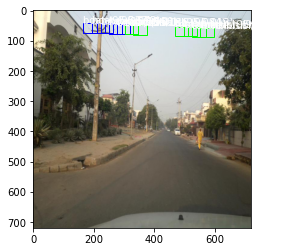

In [55]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)